In [1]:
import pandas as pd
import numpy as np

In [2]:
log_path = 'log.log'

In [3]:
def log_parser(string):
  timestamp, logger_name, log_ctx, msg = string.split(' - ')
  msg_ctx, msg_str = msg.split(':', 1)
  return (
    timestamp, 
    logger_name, 
    log_ctx, 
    msg_ctx.strip(),
    msg_str.strip()
  )

In [4]:
df_log = pd.read_csv(log_path, sep=' - ', names=['timestamp', 'logger', 'ctx', 'msg'])
df_log[['msg_ctx', 'msg']] = df_log['msg'].str.split(':', expand=True, n=1)
df_log['msg'] = df_log['msg'].apply(lambda x: x.strip())
df_log

C:\Users\62896\AppData\Local\Temp\ipykernel_10520\3990417075.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_log = pd.read_csv(log_path, sep=' - ', names=['timestamp', 'logger', 'ctx', 'msg'])


,timestamp,logger,ctx,msg,msg_ctx
0,"2023-07-15 14:28:01,906",BaseServer,INFO,clear_cache,invoked
1,"2023-07-15 14:28:01,908",ClientServer [000],INFO,clear_cache,invoked
2,"2023-07-15 14:28:01,909",ClientServer [001],INFO,clear_cache,invoked
3,"2023-07-15 14:28:01,909",ClientServer [002],INFO,clear_cache,invoked
4,"2023-07-15 14:28:01,909",ClientServer [003],INFO,clear_cache,invoked
...,...,...,...,...,...
41379,"2023-07-15 14:28:28,146",BaseServer,INFO,disk_usage_calc,invoked
41380,"2023-07-15 14:28:28,151",BaseServer,INFO,recalculated disk usage BaseServer: 8490000000...,event
41381,"2023-07-15 14:28:28,151",ClientServer [019],INFO,cache_overflow,invoked
41382,"2023-07-15 14:28:28,151",ClientServer [019],INFO,disk_usage_calc,invoked


In [5]:
df_log_events = df_log

df_log_events = df_log_events[df_log_events['msg_ctx'] == 'event']
df_log_events = df_log_events[df_log_events['msg'].str.startswith('cache')]
df_log_events[['msg', 'msg_trail']] = df_log_events['msg'].str.extract(r'(cache (?:missed|hit))(.*)')

df_log_events

,timestamp,logger,ctx,msg,msg_ctx,msg_trail
22,"2023-07-15 14:28:01,989",ClientServer [019],INFO,cache missed,event,ClientServer [019]
25,"2023-07-15 14:28:01,991",BaseServer,INFO,cache missed,event,ClientServer [019] <- BaseServer
33,"2023-07-15 14:28:01,991",ClientServer [017],INFO,cache missed,event,ClientServer [017]
36,"2023-07-15 14:28:01,994",BaseServer,INFO,cache missed,event,ClientServer [017] <- BaseServer
44,"2023-07-15 14:28:01,994",ClientServer [011],INFO,cache missed,event,ClientServer [011]
...,...,...,...,...,...,...
41355,"2023-07-15 14:28:28,126",BaseServer,INFO,cache hit,event,ClientServer [000] <- BaseServer
41363,"2023-07-15 14:28:28,136",ClientServer [011],INFO,cache missed,event,ClientServer [011]
41366,"2023-07-15 14:28:28,136",BaseServer,INFO,cache hit,event,ClientServer [011] <- BaseServer
41374,"2023-07-15 14:28:28,146",ClientServer [019],INFO,cache missed,event,ClientServer [019]


<AxesSubplot:>

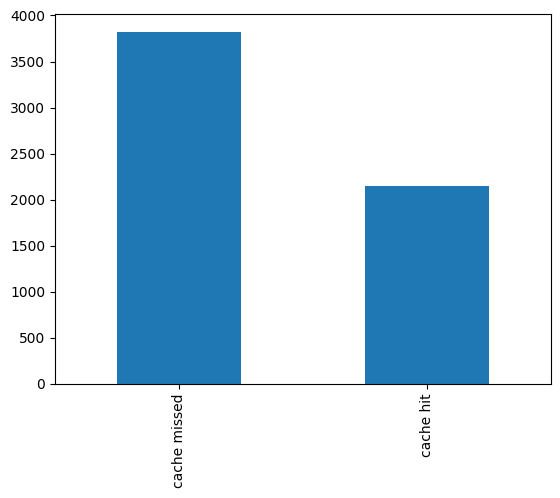

In [6]:
df_log_events['msg'].value_counts(sort=False).plot.bar()

In [7]:
df_log_events['i'] = 1
log_event_gr_sum = df_log_events[['logger', 'msg', 'i']].groupby(['logger', 'msg']).sum()

log_event_gr_sum

i
logger             msg               
BaseServer         cache hit     2125
                   cache missed   849
ClientServer [000] cache hit        2
                   cache missed   141
ClientServer [001] cache hit        3
                   cache missed   162
ClientServer [002] cache missed   167
ClientServer [003] cache missed   153
ClientServer [004] cache hit        2
                   cache missed   157
ClientServer [005] cache hit        1
                   cache missed   145
ClientServer [006] cache hit        2
                   cache missed   136
ClientServer [007] cache hit        1
                   cache missed   147
ClientServer [008] cache hit        2
                   cache missed   165
ClientServer [009] cache missed   150
ClientServer [010] cache missed   166
ClientServer [011] cache hit        2
                   cache missed   134
ClientServer [012] cache missed   147
ClientServer [013] cache hit        2
                   cache missed   154
ClientServer [014] cache hit        2
                   cache missed   135
ClientServer [015] cache hit        3
                   cache missed   143
ClientServer [016] cache hit        2
                   cache missed   140
ClientServer [017] cache missed   166
ClientServer [018] cache hit        2
                   cache missed   119
ClientServer [019] cache hit        1
                   cache missed   147

<AxesSubplot:title={'center':'cache hit ratio'}, xlabel='logger'>

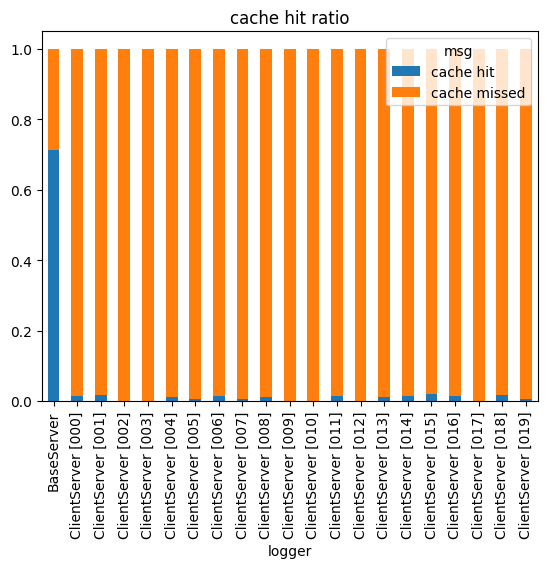

In [10]:
df_piv_log_events = df_log_events.pivot_table(index='logger', columns='msg', values='i', aggfunc='sum')
df_piv_log_events = df_piv_log_events.fillna(0)
df_piv_log_events.divide(df_piv_log_events.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title='cache hit ratio')

